In [ ]:
!pip install ppscore

In [ ]:
import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

import ppscore as pps

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

from lightgbm import LGBMRegressor
from lightgbm import plot_importance

from math import sqrt

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.2f}'.format

In [ ]:
data_dir = '/kaggle/input/predict-volcanic-eruptions-ingv-oe/'

In [ ]:
train_df = pd.read_csv(data_dir + 'train.csv')
train_df.head()

In [ ]:
train_df.describe()

In [ ]:
sns.distplot(train_df['time_to_eruption'], bins=40)

In [ ]:
min_time_seg = train_df[train_df['time_to_eruption'] == train_df['time_to_eruption'].quantile(0.1)]\
                .iloc[0]['segment_id']

median_time_seg = train_df[train_df['time_to_eruption'] == train_df['time_to_eruption'].median()]\
                   .iloc[0]['segment_id']

max_time_seg = train_df[train_df['time_to_eruption'] == train_df['time_to_eruption'].quantile(0.7)]\
                .iloc[0]['segment_id']

print('Minimum time segment -> %i (time: %i)'%(min_time_seg, train_df['time_to_eruption'].quantile(0.1)))
print('Median time segment -> %i (time: %i)'%(median_time_seg, train_df['time_to_eruption'].median()))
print('Maximum time segment -> %i (time: %i)'%(max_time_seg, train_df['time_to_eruption'].quantile(0.9)))

In [ ]:
example_df = pd.read_csv(data_dir + 'train/%i.csv'%(min_time_seg))

rcParams['figure.figsize'] = 12, 20
example_df.plot(kind = 'line', subplots = True)

plt.savefig('min_seg_signals.png', transparent = True)

In [ ]:
example_df = pd.read_csv(data_dir + 'train/%i.csv'%(median_time_seg))

rcParams['figure.figsize'] = 12, 20
example_df.plot(kind = 'line', subplots = True)

plt.savefig('median_seg_signals.png', transparent = True)

In [ ]:
example_df = pd.read_csv(data_dir + 'train/%i.csv'%(max_time_seg))

rcParams['figure.figsize'] = 12, 20
example_df.plot(kind = 'line', subplots = True)

plt.savefig('max_seg_signals.png', transparent = True)

In [ ]:
del example_df

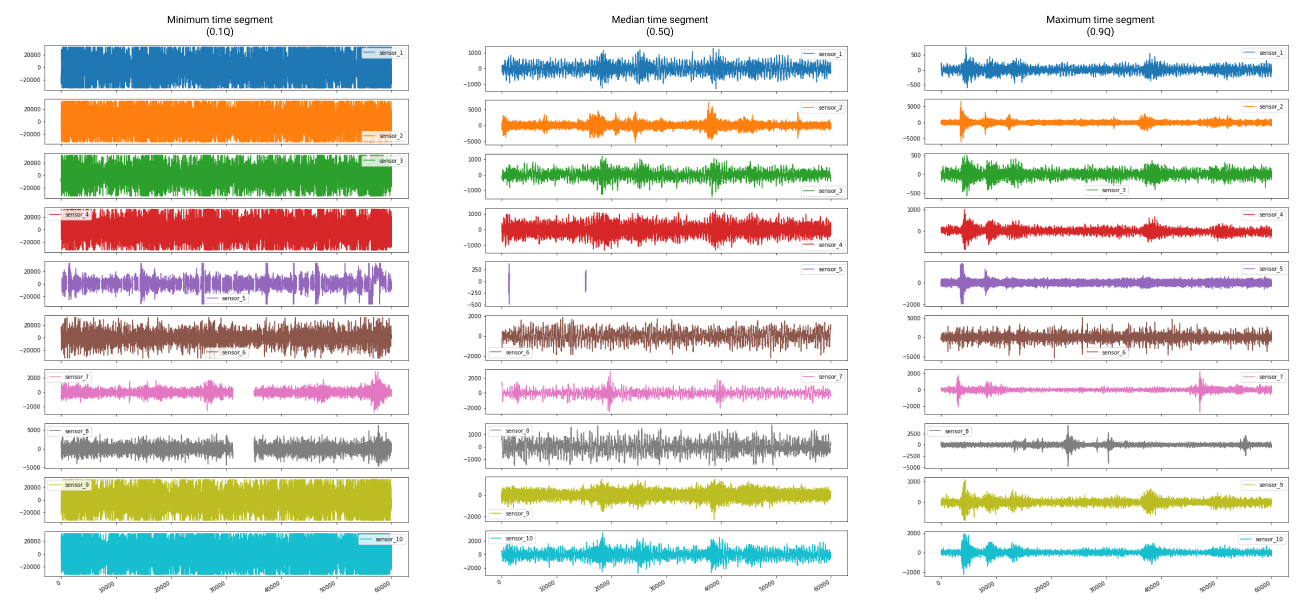

**Comparing the signs, we realize that:**
* The shorter the time, the greater the instability of the signals
* The shorter the time, the greater the signal amplitude
* The signal peaks coincide by the sensors
* Number of NaNs can mean something

median, max, min, std, skew, kurtosis, number of NaNs, .95q, 0.05q, max - min, positive peaks, negative peaks,  

In [ ]:
def get_stats(files_folder, segs_df):
    files_dir = data_dir + files_folder
    
    df = segs_df.copy()
    df.set_index('segment_id', inplace = True)

    for file in tqdm(os.listdir(files_dir)):
        file_df = pd.read_csv(files_dir + file, dtype="Int16")

        for sensor in file_df.columns:
            df.loc[int(file[:-4]), '%s_max'%(sensor)] = file_df.loc[:, sensor].max()
            df.loc[int(file[:-4]), '%s_min'%(sensor)] = file_df.loc[:, sensor].min()
            df.loc[int(file[:-4]), '%s_std'%(sensor)] = file_df.loc[:, sensor].std()
            df.loc[int(file[:-4]), '%s_skew'%(sensor)] = file_df.loc[:, sensor].skew()
            df.loc[int(file[:-4]), '%s_kurtosis'%(sensor)] = file_df.loc[:, sensor].kurtosis()

            df.loc[int(file[:-4]), '%s_nan'%(sensor)] = file_df.loc[:, sensor].isna().sum()

            df.loc[int(file[:-4]), '%s_99q'%(sensor)] = file_df.loc[:, sensor].quantile(.99)
            df.loc[int(file[:-4]), '%s_01q'%(sensor)] = file_df.loc[:, sensor].quantile(.01)

            df.loc[int(file[:-4]), '%s_amplitude'%(sensor)] = df.loc[int(file[:-4]), '%s_max'%(sensor)] -\
                                                              df.loc[int(file[:-4]), '%s_min'%(sensor)]

            df.loc[int(file[:-4]), '%s_neg_peaks'%(sensor)] = (file_df.loc[:, sensor] <=\
                                                               df.loc[int(file[:-4]), '%s_01q'%(sensor)]).sum()
            df.loc[int(file[:-4]), '%s_pos_peaks'%(sensor)] = (file_df.loc[:, sensor] >=\
                                                               df.loc[int(file[:-4]), '%s_99q'%(sensor)]).sum()

    df.reset_index(inplace = True)

    return df

In [ ]:
stats_train_df = get_stats('train/', train_df)

test_df = pd.DataFrame(columns=['segment_id'])
test_df['segment_id'] = [int(file_name[:-4]) for file_name in os.listdir(data_dir + 'test/')]

stats_test_df = get_stats('test/', test_df)

In [ ]:
del train_df
del test_df

In [ ]:
stats_train_df['percent_missing_sensors'] = (stats_train_df.isna().sum(axis=1) +\
                                             (stats_train_df.isna().sum(axis=1)/8)*2)/100

stats_test_df['percent_missing_sensors'] = (stats_test_df.isna().sum(axis=1) +\
                                             (stats_test_df.isna().sum(axis=1)/8)*2)/100

## Top variables

### Top 30 correlations

In [ ]:
corr = stats_train_df.corr('pearson')[['time_to_eruption']].dropna()
corr = corr.sort_values('time_to_eruption')
corr = corr.drop(index=['time_to_eruption'])

top_corr = pd.concat([corr.head(15), corr.tail(15)])
top_corr.rename(columns={'time_to_eruption':'time_to_eruption_corr'}, inplace = True)

rcParams['figure.figsize'] = 15, 7
sns.barplot(data = top_corr.reset_index(), y='index', x='time_to_eruption_corr')

### PPScore

In [ ]:
top_predictors = pps.predictors(stats_train_df, y='time_to_eruption').loc[:26]

rcParams['figure.figsize'] = 15, 7
sns.barplot(data=top_predictors, y='x', x='ppscore')

* ppscore != 0

### Comparing top 5 variables with higher PPScores

In [ ]:
top_ppscore_df = stats_train_df[list(top_predictors['x'])[:5] + ['time_to_eruption']]

cut_min = top_ppscore_df['time_to_eruption'].min()
cut_25 = top_ppscore_df['time_to_eruption'].quantile(0.25)
cut_75 = top_ppscore_df['time_to_eruption'].quantile(0.75)
cut_max = top_ppscore_df['time_to_eruption'].max()

top_ppscore_df['cut_time_to_eruption'] = pd.cut(top_ppscore_df['time_to_eruption'], 
                                                bins = [cut_min, cut_25, cut_75, cut_max], 
                                                labels = ['low', 'medium', 'high'])

sns.pairplot(top_ppscore_df, hue = 'cut_time_to_eruption')

#### Comparing the distribution of the variables between 'train' and 'test'

In [ ]:
top_ppscore_df_train = stats_train_df[list(top_predictors['x'])[:5]]
top_ppscore_df_test = stats_test_df[list(top_predictors['x'])[:5]]

top_ppscore_df_train['type'] = 'train'
top_ppscore_df_test['type'] = 'test'

sns.pairplot(pd.concat([top_ppscore_df_train, top_ppscore_df_test]), hue = 'type')

* similar distribution between training and testing

In [ ]:
del top_corr
del top_predictors
del top_ppscore_df
del top_ppscore_df_train
del top_ppscore_df_test

In [ ]:
stats_train_df.fillna(0, inplace = True)
stats_test_df.fillna(0, inplace = True)

## Train LGBM

In [ ]:
def RMSE(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
cv = KFold(n_splits = 5, shuffle=True, random_state=42)

In [ ]:
x = stats_train_df.drop(columns=['segment_id', 'time_to_eruption'])
y = stats_train_df['time_to_eruption']

In [ ]:
train_scores = []
val_scores = []

pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('lgbm', LGBMRegressor(n_estimators=1000, 
                                            max_depth=14,
                                            num_leaves=45,
                                            learning_rate=0.1,
                                            min_child_samples=20,
                                            subsample=.9,
                                            colsample_bytree=.9,
                                            random_state=42, 
                                            eval_metric='rmse'))])

for train_index, val_index in cv.split(stats_train_df):
    x_train, x_val = x.iloc[train_index], x.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    pipeline.fit(x_train, y_train)
    
    y_train_pred = pipeline.predict(x_train)
    y_val_pred = pipeline.predict(x_val)
    
    train_score = RMSE(y_train, y_train_pred)
    val_score = RMSE(y_val, y_val_pred)
    
    train_scores.append(train_score)
    val_scores.append(val_score)
    
    print('Train score = %.2f'%(train_score))
    print('Validation score = %.2f'%(val_score))
    print()
    
print('VALIDATION SCORE = %.2f+/-%.2f'%(np.array(val_scores).mean(), np.array(val_scores).std()))

In [ ]:
pipeline.fit(x, y)

In [ ]:
feat_importance = pd.DataFrame(data = pipeline['lgbm'].feature_importances_, columns=['value'])
feat_importance['name'] = x.columns
feat_importance.sort_values('value', inplace = True)

rcParams['figure.figsize'] = 15, 30
sns.barplot(data = feat_importance.reset_index(), y='name', x='value')

In [ ]:
stats_test_df['time_to_eruption'] = pipeline.predict(stats_test_df.drop(columns=['segment_id']))